# Features quering with filtering based on properties

Common geospatial services include filtering by the Area of Interest.
It is important they do as the service usually contain vast amount of data and must be queried carefully.
Modern interfaces like OGC API Features provide efficient 
However, with the variety of extensions of generic interfaces, like OGC API Features (previously WFS), custom properties are added that are not neccesarily indexed and queryable depending on the backend and service configuration. Additionally, they can be exended in various ways and the exact mapping between data and their semantic can be ambiguous.

In any case, data queried can be analysed including properties to filter, classify, sort, join etc.
Sparql language gives 

In this examples, generic OGC API fertures is extended with custom, domain specific properties. Ocean Information Model integration is done though JSON-LD context that can be set in other place (here are OGC Incubator Building blocks). Example shows how data can be queries and processed on the client endpoint 

In [1]:
#check if all the packages are installed
!pip install folium rdflib streamlit-folium


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Import necessary libraries
import requests
import json

#Define the HTTP endpoint URL, this static data is test proven, it can be changed to live features service and query parameters can be provided inline
url = "https://ogcincubator.github.io/iliad-apis-features/build/tests/hosted/iliad/api/features/iliad-jellyfish/example_1_1.json"
# Fetch data from the HTTP endpoint
response = requests.get(url)
data = response.json()
data

{'@id': '1-18-527-Phyllorhiza_punctata',
 'type': 'Feature',
 'featureType': 'sosa:Observation',
 'geometry': {'type': 'Point', 'coordinates': [31.80691, 34.634776]},
 'properties': {'label': {'en': 'Jelly fish observation #1 location id: 18 sensor: 527 species: Phyllorhiza punctata'},
  'phenomenonTime': '2011-07-01T09:00:00',
  'resultTime': '2011-07-01T09:00:00',
  'observedProperty': 'jellyFishAbundanceProperty',
  'hasFeatureOfInterest': '1-18',
  'hasResult': {'densityOfJF': 'Some',
   'quantityOfJF': 50,
   'sampleSizeValue': '10-30',
   'speciesScientificName': 'Phyllorhiza punctata',
   'wormsConcept': 'https://marinespecies.org/aphia.php?p=taxdetails&id=135298',
   'stingByJF': 'Unspecified',
   'beachedJF': '1'}}}

# map visualisation 
Thanks to the standard format of data output, it can be easily visualised on client application like QGIS, ArcGIS or web frameworks like Openlayers or Leaflet
Let's see how the data looks like in this case.
You'll see that this small sample is representing one occurence, represented as 'feature' in geospatial language.

## data fixing
In the previous example, we've detected that the latitude and longitude were incorrect, it should not occur with the real data but let's fix example.
in the geojson, coordinates of point shall represent longiture and latitude
'coordinates': [31.80691, 34.634776] is 34°38'05.2"N 31°48'24.9"E, somewhere around Cyprus
'coordinates': [34.634776, 31.80691] is 34°38'05.2"E 31°48'24.9"N, somewhere around on the Israel coast

In [3]:
#coordinates swap
lat = data['geometry']['coordinates'][0]
data['geometry']['coordinates'][0] = data['geometry']['coordinates'][1]
data['geometry']['coordinates'][1] = lat
data

{'@id': '1-18-527-Phyllorhiza_punctata',
 'type': 'Feature',
 'featureType': 'sosa:Observation',
 'geometry': {'type': 'Point', 'coordinates': [34.634776, 31.80691]},
 'properties': {'label': {'en': 'Jelly fish observation #1 location id: 18 sensor: 527 species: Phyllorhiza punctata'},
  'phenomenonTime': '2011-07-01T09:00:00',
  'resultTime': '2011-07-01T09:00:00',
  'observedProperty': 'jellyFishAbundanceProperty',
  'hasFeatureOfInterest': '1-18',
  'hasResult': {'densityOfJF': 'Some',
   'quantityOfJF': 50,
   'sampleSizeValue': '10-30',
   'speciesScientificName': 'Phyllorhiza punctata',
   'wormsConcept': 'https://marinespecies.org/aphia.php?p=taxdetails&id=135298',
   'stingByJF': 'Unspecified',
   'beachedJF': '1'}}}

In [4]:
import folium

#create visualisation function and use it first time
def map_features(data, center, zoom):
    # Create a map centered around the coordinates
    m = folium.Map(location = center, zoom_start = zoom)
    # Add GeoJSON data to the map
    folium.GeoJson(data, name="geojson").add_to(m)
    # Add a layer control panel to the map
    folium.LayerControl().add_to(m)
    #return map in case it needs to be updated
    return m 

# Display the map in a Jupyter Notebook (if using one)
map_features(data=data, center=[31.80691, 34.634776],zoom=8)

In [5]:

ld_context = "https://ogcincubator.github.io/iliad-apis-features/build/annotated/hosted/iliad/api/features/iliad-jellyfish/context.jsonld"
# Fetch data from the HTTP endpoint
response = requests.get(ld_context)
context = response.json()
context

{'@context': {'resultTime': 'sosa:resultTime',
  'phenomenonTime': {'@id': 'sosa:phenomenonTime', '@type': '@id'},
  'hasFeatureOfInterest': {'@id': 'sosa:hasFeatureOfInterest', '@type': '@id'},
  'observedProperty': {'@context': {'@base': 'https://w3id.org/iliad/jellyfish/property/'},
   '@id': 'sosa:observedProperty',
   '@type': '@id'},
  'usedProcedure': {'@id': 'sosa:usedProcedure', '@type': '@id'},
  'madeBySensor': {'@id': 'sosa:madeBySensor', '@type': '@id'},
  'id': '@id',
  'properties': '@nest',
  'featureType': '@type',
  'ActuatableProperty': {'@id': 'sosa:ActuatableProperty', '@type': '@id'},
  'Actuation': {'@id': 'sosa:Actuation', '@type': '@id'},
  'ActuationCollection': {'@id': 'sosa:ActuationCollection', '@type': '@id'},
  'Actuator': {'@id': 'sosa:Actuator', '@type': '@id'},
  'Deployment': {'@id': 'sosa:Deployment', '@type': '@id'},
  'Execution': {'@id': 'sosa:Execution', '@type': '@id'},
  'FeatureOfInterest': {'@id': 'sosa:FeatureOfInterest', '@type': '@id'},
  

In [6]:
from rdflib import Graph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS, XSD

def json_to_rdf(data):
    data_with_context = {
    "@context": context["@context"],
    "@graph": data
    }
    # Convert JSON-LD to RDF
    g = Graph()
    g.parse(data=json.dumps(data_with_context), format='json-ld')

    # Print the RDF data
    g_ttl = g.serialize(format='turtle')
    return g_ttl, g

g_ttl, g = json_to_rdf(data)
print(g_ttl)



@prefix geojson: <https://purl.org/geojson/vocab#> .
@prefix iliad: <https://w3id.org/iliad/property/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/1-18-527-Phyllorhiza_punctata> a sosa:Observation,
        geojson:Feature ;
    rdfs:label "Jelly fish observation #1 location id: 18 sensor: 527 species: Phyllorhiza punctata"@en ;
    sosa:hasFeatureOfInterest <file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/1-18> ;
    sosa:hasResult [ iliad:sampleSizeValue "10-30" ;
            iliad:speciesScientificName "Phyllorhiza punctata" ;
            iliad:wormsConcept <https://marinespecies.org/aphia.php?p=taxdetails&id=135298> ] ;
    sosa:observedProperty <https://w3id.org/iliad/jellyfish/property/jellyFishAbundanc

In [7]:
# Define the SPARQL query to filter out specific types of observations
query = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX jf-property: <https://w3id.org/iliad/jellyfish/property/>
PREFIX geojson: <https://purl.org/geojson/vocab#>
PREFIX iliad: <https://w3id.org/iliad/property/>

SELECT ?observation ?quantity ?coordinates ?species ?latitude ?longitude
WHERE {
?observation a sosa:Observation ;
    sosa:hasResult ?result ;
    geojson:geometry ?geometry ;
    sosa:observedProperty jf-property:jellyFishAbundanceProperty .
?result jf-property:quantityOfJF ?quantity ;
    jf-property:densityOfJF ?density ;
    iliad:speciesScientificName ?species .
?geometry geojson:coordinates ?coordinates .
?coordinates rdf:first ?latitude ;
        rdf:rest/rdf:first ?longitude .
}
"""

# Execute the SPARQL query on the RDF graph
results = g.query(query)

# Process and print the results
output = ""
for result in results:
    observation = result["observation"]
    quantity = result["quantity"]
    coordinates = result["coordinates"]
    latitude = result["latitude"]
    longitude = result["longitude"]
    species = result["species"]
    output = output + f"Observation: {observation}, Quantity: {quantity}, Coordinates: {latitude} {longitude}, Species: {species}"

output

''

In [8]:
# Process and print the results
output = ""
for result in results:
    observation = result["observation"]
    quantity = result["quantity"]
    coordinates = result["coordinates"]
    output = output + "\n" + f"Observation: {observation}, Quantity: {quantity}, Coordinates: {coordinates}"

output

''

# now query your own endpoint
In the following examples, client application will query data from custom endpoin exposing standardised API, context definition in these cases is also external

In [33]:
url = "http://localhost:5002/collections/my-observations-schema.org/items?f=json&limit=100"
#we'll keep data in as object for some experiments
data2 = requests.get(url).json()
len(data2)

6

In [32]:
#We're using previously defined function to put on the map in the same style but different data
#Mind, that data is in the standards format comlioent with GeoJSON, OGC API Features, OGC API EDR Items, OGC API Records. Each of these shall behave similarily
map_features(data2,[31.80691, 34.634776],7)



In [12]:
!pip install pyshacl



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [35]:
import pyshacl

data3=requests.get('http://localhost:5002/collections/my-observations-schema.org/items?f=json&offset=1&limit=100').json()

shacl_rules_url = 'https://opengeospatial.github.io/ogcapi-sosa/_sources/features/observation/semantic-uplift/featureType.shacl'

shacl_graph = Graph().parse(shacl_rules_url, format='ttl')

json_ld_data = json.dumps({**context, **data3}, indent=2)

print(json_ld_data)




{
  "@context": {
    "resultTime": "sosa:resultTime",
    "phenomenonTime": {
      "@id": "sosa:phenomenonTime",
      "@type": "@id"
    },
    "hasFeatureOfInterest": {
      "@id": "sosa:hasFeatureOfInterest",
      "@type": "@id"
    },
    "observedProperty": {
      "@context": {
        "@base": "https://w3id.org/iliad/jellyfish/property/"
      },
      "@id": "sosa:observedProperty",
      "@type": "@id"
    },
    "usedProcedure": {
      "@id": "sosa:usedProcedure",
      "@type": "@id"
    },
    "madeBySensor": {
      "@id": "sosa:madeBySensor",
      "@type": "@id"
    },
    "id": "@id",
    "properties": "@nest",
    "featureType": "@type",
    "ActuatableProperty": {
      "@id": "sosa:ActuatableProperty",
      "@type": "@id"
    },
    "Actuation": {
      "@id": "sosa:Actuation",
      "@type": "@id"
    },
    "ActuationCollection": {
      "@id": "sosa:ActuationCollection",
      "@type": "@id"
    },
    "Actuator": {
      "@id": "sosa:Actuator",
      "@type

In [36]:
data_graph = Graph().parse(data=json_ld_data, format='json-ld', base=url)
pyshacl.validate(data_graph, shacl_graph, advanced=True, in_place=True)

print(data_graph.serialize(format='ttl'))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix geojson: <https://purl.org/geojson/vocab#> .
@prefix iliad: <https://w3id.org/iliad/property/> .
@prefix ns1: <http://www.iana.org/assignments/> .
@prefix ns2: <https://w3id.org/iliad/oim/ext/jellyfish/> .
@prefix oa: <http://www.w3.org/ns/oa#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://localhost:5002/collections/my-observations-schema.org/Jellyfish_in_Israeli_Mediterranean_coast1440728.750-> a geojson:Feature ;
    dcterms:date "04/07/2011" ;
    dcterms:time "18:00" ;
    geojson:geometry [ a geojson:Point ;
            geojson:coordinates ( 3.456848e+01 3.180974e+01 ) ] ;
    ns2:strandedJellyfish 1 ;
    iliad:sampleSizeValue 0 .

<http://localhost:5002/collections/my-observations-schema.org/Jellyfish_in_Israeli_Mediterranean_coast2340729.54166666670

In [84]:
data3 = {
   '@id': 'Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Rhizostoma_pulmo',

   'geometry': {'type': 'Point', 'coordinates': [34.634776, 31.80691]},

 'featureType': 'sosa:Observation',
   'properties': {'occurrence': 'Jellyfish_in_Israeli_Mediterranean_coast',
    'eventDate_ori': '01/07/2011 9:00',
    'date': '07/01/2011',
    'dateFix': '07/01/2011',
    'time': '9:00',
    'eventDate': '2011-07-01T09:00:00',
    'decimalLongitude_ori': 34.634776,
    'decimalLatitude_ori': 31.80691,
    'scientificName': 'Rhizostoma pulmo',
    'occurrenceStatus': 'present',
    'basisOfRecord': 'HumanObservation',
    'scientificNameID': 'http://marinespecies.org/aphia.php?p=taxdetails&id=135299',
    'recordedBy': 527,
    'quantificationMethod': 'Other',
    'organismQuantity': 'Some',
    'organismQuantityType': 'Individuals',
    'sampleSizeUnit': 'cm',
    'sampleSizeValue': '10-30',
    'MachineObservation': '-',
    'eventType': 0,
    'coordinateUncertaintyInMeters': 1000,
    'strandedJellyfish': 1,
    'goldUser': 1,
    'Stinging_Water': 'Unspecified',
    'distanceWalkedinmeters': '-',
    'obsID': 1,
    'Location_20_Zones_ID': 18,
    'Distance_from_coast': '200-1000',
    'Quantity_Reported': 10}}

In [85]:
#GeoJSON is nicely handled by the map implementations. As the current data is a collection, one could navigate through it with  but can include various data in properties of 'feature'and we'll parse it into 
#g_ttl2, g2 = json_to_rdf(data2)

# data_with_context2 = data3
# data_with_context2["@context"] = 'https://ogcincubator.github.io/iliad-apis-features/build/annotated/hosted/iliad/api/features/iliad-jellyfish/context.jsonld'
data_with_context2 = {
    "@context": context["@context"],
    "@graph": data3
    }
    # Convert JSON-LD to RDF
g2 = Graph()
g2.parse(data=json.dumps(data_with_context2), format='json-ld')

    # Print the RDF data
g_ttl2 = g2.serialize(format='turtle')
print(g_ttl2)

@prefix dct: <http://purl.org/dc/terms/> .
@prefix geojson: <https://purl.org/geojson/vocab#> .
@prefix iliad: <https://w3id.org/iliad/property/> .
@prefix ns1: <https://w3id.org/iliad/oim/ext/jellyfish/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Rhizostoma_pulmo> a sosa:Observation ;
    dct:date "07/01/2011" ;
    dct:time "9:00" ;
    geojson:geometry [ a geojson:Point ;
            geojson:coordinates ( 3.463478e+01 3.180691e+01 ) ] ;
    ns1:strandedJellyfish 1 ;
    iliad:sampleSizeValue "10-30" .




In [15]:
#as there is no daata in the graph, we expect it was not properly mapped to OIM, but lets try to query data
# Execute the SPARQL query on the RDF graph

query = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX geojson: <https://purl.org/geojson/vocab#>

SELECT ?observation ?coordinates ?latitude ?longitude
WHERE {
?observation a sosa:Observation ;
    geojson:geometry ?geometry .
?geometry geojson:coordinates ?coordinates .
?coordinates rdf:first ?latitude ;
        rdf:rest/rdf:first ?longitude .
}
"""

results = data_graph.query(query)

# Process and print the results
output = ""
for result in results:
    observation = result["observation"]
    quantity = result["quantity"]
    coordinates = result["coordinates"]
    latitude = result["latitude"]
    longitude = result["longitude"]
    species = result["species"]
    output = output + f"Observation: {observation}, Quantity: {quantity}, Coordinates: {latitude} {longitude}, Species: {species}"

len(results)

0

In [154]:
data3=requests.get('http://localhost:5002/collections/my-observations-linked/items?f=json&offset=0&limit=1000').json()

map_features(data=data3, center=[31.80691, 34.634776],zoom=8)


In [155]:
g3 = Graph()
#g3.parse(data=json.dumps(data_with_context2), format='json-ld')
g3.parse(data=json.dumps(data3), format='json-ld')

    # Print the RDF data
g_ttl3 = g3.serialize(format='turtle')
print(g_ttl3)

@prefix dct: <http://purl.org/dc/terms/> .
@prefix geojson: <https://purl.org/geojson/vocab#> .
@prefix iliad: <https://w3id.org/iliad/property/> .
@prefix ns1: <https://w3id.org/iliad/oim/ext/jellyfish/> .
@prefix ns2: <http://www.iana.org/assignments/> .
@prefix oa: <http://www.w3.org/ns/oa#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sosa: <http://www.w3.org/ns/sosa/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast10040734.37530-60Rhopilema_nomadica> a sosa:Observation,
        geojson:Feature ;
    dct:date "10/07/2011" ;
    dct:time "09:00" ;
    geojson:geometry [ a geojson:Point ;
            geojson:coordinates ( 3.479095e+01 3.235545e+01 ) ] ;
    ns1:strandedJellyfish 1 ;
    iliad:sampleSizeValue "30-60" .

<file:///Users/piotr/repos/Iliad/data_access_api/examples/Ob

In [145]:
# Define the SPARQL query to filter out specific types of observations
query = """
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX jf-property: <https://w3id.org/iliad/jellyfish/property/>
PREFIX geojson: <https://purl.org/geojson/vocab#>
PREFIX iliad: <https://w3id.org/iliad/property/>

SELECT ?observation ?sampleSize ?coordinates ?species ?latitude ?longitude ?date ?time
WHERE {
?observation a sosa:Observation ;
    geojson:geometry ?geometry ;
    dct:date ?date ;
    dct:time ?time ;
    iliad:sampleSizeValue ?sampleSize .
?geometry geojson:coordinates ?coordinates .
?coordinates rdf:first ?latitude ;
        rdf:rest/rdf:first ?longitude .

}
"""
def filter_list(data_graph, query):
    # Execute the SPARQL query on the RDF graph
    results = data_graph.query(query)

    # Process and print the results
    output = ""
    for result in results:
        observation = result["observation"]
        quantity = result["sampleSize"]
        coordinates = result["coordinates"]
        latitude = result["latitude"]
        longitude = result["longitude"]
        species = result["species"]
        date = result["date"]
        time = result["time"]
        output = output + "\n" + f"Observation: {observation}, Time: {date}T{time}Z,Quantity: {quantity}, Coordinates: {latitude} {longitude}, Species: {species}"
    return output

print(filter_list(g3, query))


Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37530-60Rhopilema_nomadica, Time: 01/07/2011T09:00Z,Quantity: 30-60, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Rhizostoma_pulmo, Time: 01/07/2011T09:00Z,Quantity: Oct-30, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Phyllorhiza_punctata, Time: 01/07/2011T09:00Z,Quantity: Oct-30, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast240725.37511232Rhopilema_nomadica, Time: 01/07/2011T09:00Z,Quantity: Oct-30, Coordinates: 34.88873 3

In [152]:
query = """PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX jf-property: <https://w3id.org/iliad/jellyfish/property/>
PREFIX geojson: <https://purl.org/geojson/vocab#>
PREFIX iliad: <https://w3id.org/iliad/property/>

SELECT ?observation ?sampleSize ?coordinates ?species ?latitude ?longitude ?originalDate (CONCAT(SUBSTR(?originalDate, 7, 4), "-", 
                             SUBSTR(?originalDate, 4, 2), "-", 
                             SUBSTR(?originalDate, 1, 2)) AS ?date
)
 ?time
WHERE {
?observation a sosa:Observation ;
    geojson:geometry ?geometry ;
    dct:date ?originalDate ;
    dct:time ?time ;
    iliad:sampleSizeValue ?sampleSize .
?geometry geojson:coordinates ?coordinates .
?coordinates rdf:first ?latitude ;
        rdf:rest/rdf:first ?longitude .

  BIND(CONCAT(SUBSTR(?originalDate, 7, 4), "-", 
              SUBSTR(?originalDate, 4, 2), "-", 
              SUBSTR(?originalDate, 1, 2)) AS ?date)

FILTER (?date >= "2011-07-01" && ?date <= "2011-07-02")
}
ORDER BY ?species ?date
"""
print(filter_list(g3, query))



Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37530-60Rhopilema_nomadica, Time: 2011-07-01T09:00Z,Quantity: 30-60, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Rhizostoma_pulmo, Time: 2011-07-01T09:00Z,Quantity: Oct-30, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast140725.37511232Phyllorhiza_punctata, Time: 2011-07-01T09:00Z,Quantity: Oct-30, Coordinates: 34.634776 31.80691, Species: None
Observation: file:///Users/piotr/repos/Iliad/data_access_api/examples/Observations_Features/Jellyfish_in_Israeli_Mediterranean_coast240725.37511232Rhopilema_nomadica, Time: 2011-07-01T09:00Z,Quantity: Oct-30, Coordinates: 34.88873 3

In [159]:
#filter and group by month
query = """PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX jf-property: <https://w3id.org/iliad/jellyfish/property/>
PREFIX geojson: <https://purl.org/geojson/vocab#>
PREFIX iliad: <https://w3id.org/iliad/property/>

SELECT  ?slice (COUNT(?observation) AS ?count) (AVG(?latitude) AS ?avgLat) (AVG(?longitude) AS ?avgLon)

WHERE {
?observation a sosa:Observation ;
    geojson:geometry ?geometry ;
    dct:date ?originalDate ;
    dct:time ?time ;
    iliad:sampleSizeValue ?sampleSize .
?geometry geojson:coordinates ?coordinates .
?coordinates rdf:first ?latitude ;
        rdf:rest/rdf:first ?longitude .

BIND(CONCAT(SUBSTR(?originalDate, 7, 4), "-", 
              SUBSTR(?originalDate, 4, 2), "-", 
              SUBSTR(?originalDate, 1, 2)) AS ?date)

BIND(CONCAT(SUBSTR(?originalDate, 7, 4), "-", 
              SUBSTR(?originalDate, 4, 2), "-", 
              SUBSTR(?originalDate, 1, 2)) AS ?slice)


FILTER (?date >= "2011-07-01" && ?date <= "2011-07-31")
}
GROUP BY ?slice
ORDER BY ?slice
"""
results = g3.query(query)

    # Process and print the results
output = ""
for result in results:
        count = result["count"]
        slice = result["slice"]
        avgLat = result["avgLat"]
        avgLon = result["avgLon"]
        output = output + "\n" + f"Count: {count}, slice: {slice}, avgLat {avgLat}, avgLon {avgLon}"
print(output)



Count: 8, slice: 2011-07-01, avgLat 34.756831625000004, avgLon 32.183886
Count: 1, slice: 2011-07-02, avgLat 34.94339, avgLon 32.849519
Count: 3, slice: 2011-07-03, avgLat 34.568481, avgLon 31.809738999999997
Count: 14, slice: 2011-07-04, avgLat 34.812816714285724, avgLon 32.376218
Count: 19, slice: 2011-07-05, avgLat 34.79606405263157, avgLon 32.353970421052644
Count: 7, slice: 2011-07-06, avgLat 34.76628485714285, avgLon 32.25397785714286
Count: 14, slice: 2011-07-07, avgLat 34.77278785714286, avgLon 32.301215285714285
Count: 50, slice: 2011-07-08, avgLat 34.739530819999985, avgLon 32.23324826000002
Count: 23, slice: 2011-07-09, avgLat 34.746921652173924, avgLon 32.276052739130435
Count: 13, slice: 2011-07-10, avgLat 34.718831692307695, avgLon 32.18280092307692
Count: 11, slice: 2011-07-11, avgLat 34.840018727272735, avgLon 32.53041581818181
Count: 11, slice: 2011-07-12, avgLat 34.82089436363636, avgLon 32.47567227272727
Count: 7, slice: 2011-07-13, avgLat 34.83444685714286, avgLon 

In [172]:
import folium
m = folium.Map(center=[31.80691, 34.634776], zoom_start=5)

for obs in results:
    # Add a marker for the computed central point
    folium.Marker(
        [obs.avgLon,obs.avgLat], 
        popup=f"Average Observation Location {slice} lat:{obs.avgLat},lon:{obs.avgLon}",
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(m)
'''
#here could be a line between the points, but it is not real tracking so it does not make sense
coords = [(float(obs.avgLon),float(obs.avgLat)) for obs in results]
folium.PolyLine(coords, color="blue", weight=4, opacity=0.7).add_to(m)

# Add directional markers manually
for i in range(len(coords) - 1):
    mid_lat = (coords[i][0] + coords[i + 1][0]) / 2
    mid_long = (coords[i][1] + coords[i + 1][1]) / 2
    
    folium.Marker(
        [mid_lat, mid_long],
        icon=folium.DivIcon(html="""<div style='font-size:18px; color:blue;'>&#10138;</div>""")  # Arrow symbol
    ).add_to(m)
'''

# Save as HTML file
m



In [42]:
!pip install rdflib networkx matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


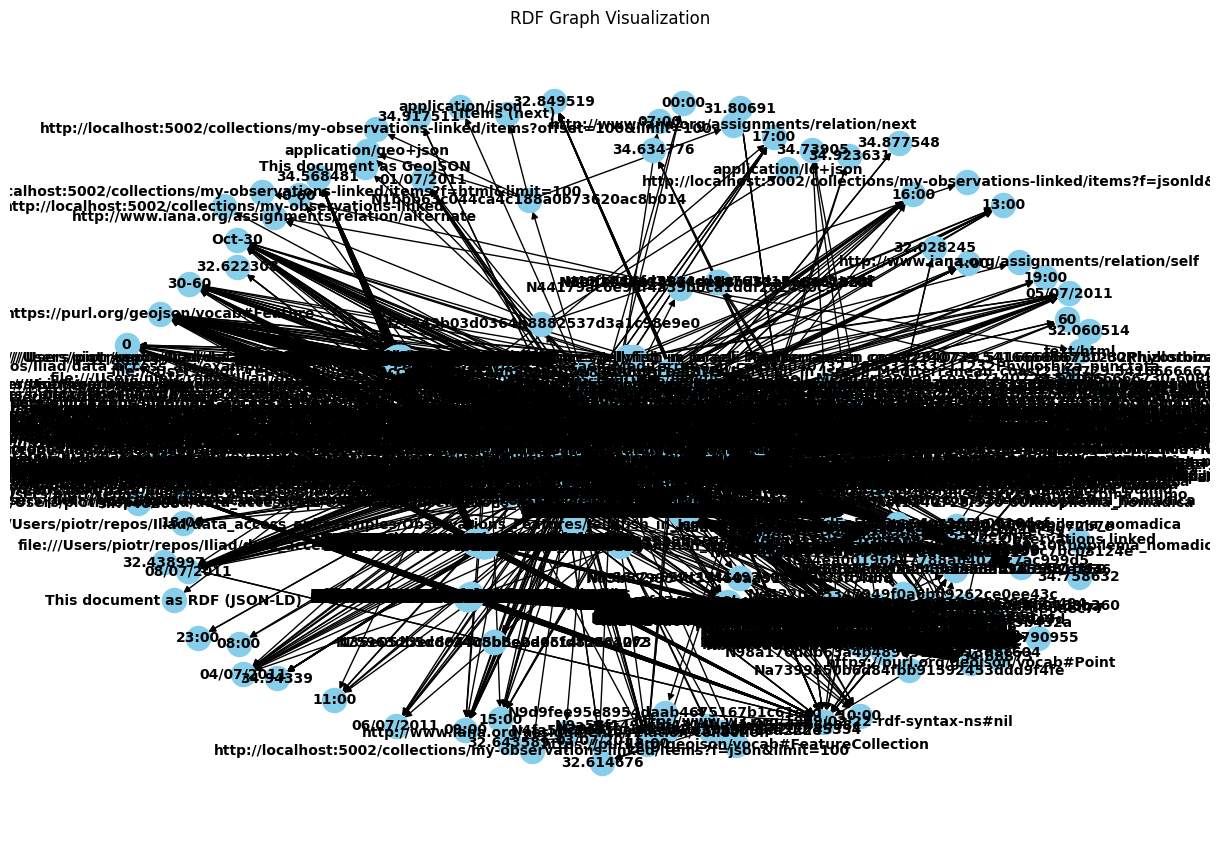

In [44]:
import rdflib
import networkx as nx
import matplotlib.pyplot as plt

# Convert RDF graph to NetworkX graph
G = nx.DiGraph()

for s, p, o in g3:
    G.add_edge(s, o, label=p)

# Draw the graph
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=300, node_color="skyblue", font_size=10, font_weight="bold", arrows=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title("RDF Graph Visualization")
plt.show()